# Validating fine-tuned Generator via behavioural real-world data 
- using Wahlomat survey to compare generated results versus real-world party answers from the 2025 Bundestagswahl

In [1]:
# Setup -load packages
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from matplotlib.colors import LinearSegmentedColormap
import re

# load data 
wahlomat_data = pd.read_csv("../data/Wahl-O-Mat_results_sys_adapted_V2.csv")
# renaming Union into CDU/CSU
wahlomat_data['party'].replace('Union','CDU/CSU',inplace=True)
wahlomat_data['party'].value_counts()


/var/folders/jp/7rxct1gj4xsc_51ldxz05w9w0000gn/T/ipykernel_8821/3467023875.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wahlomat_data['party'].replace('Union','CDU/CSU',inplace=True)


party
SPD        38
CDU/CSU    38
GRÜNE      38
FDP        38
AfD        38
LINKE      38
Name: count, dtype: int64

_________________________________________________________________
Extracting answers from generated responses
__________________________________________________________________

In [2]:
# editing the answers in new column: all to lower case, removing all punctuation
wahlomat_data["model_answer_01_edit"] = wahlomat_data["model_answer_01"].str.lower().str.translate(str.maketrans('', '', string.punctuation)).str.replace(r'\[.*?\]', '', regex=True).str[:35]
wahlomat_data["model_answer_03_edit"] = wahlomat_data["model_answer_03"].str.lower().str.translate(str.maketrans('', '', string.punctuation)).str.replace(r'\[.*?\]', '', regex=True).str[:35]


In [ ]:
# function to extract right class/label from long model answers
def classify_model_answer(text):
    if not isinstance(text, str):
        return 'None'
    
    if re.search(r'\bstimmen\s+wir\s+gegen|\bstimmen\s+wir\s+ab|nein', text):
        return 'stimme nicht zu'
    
    if re.search(r'(stimme|stimm|stimmt|stimmen)\b(?:\s+\w+){0,2}?\s(dazu|zu)\b', text):
        return 'stimme zu'
    
    if re.search(r'neutral|neutrale', text):
        return 'neutral'
    
    return 'None'


# alternative function (no difference)
# def classify_model_answer(text):
#     if not isinstance(text, str):
#         return 'None'
#     if re.search(r'❌|\bstimme\s+nicht\s+zu\b|dagegen\b|ich\s+bin\s+dagegen|stimmtnichtto|ablehnung|\bstimmen\s+wir\s+ab', text):
#         return 'stimme nicht zu'
#     if re.search(r'👍|☑️|\b(stimme|stimm|stimmt|stimmen)\b(?:\s+\w+){0,2}?\s(dazu|zu)\b|stimmtzu|stimmzu|ich\s+bin\s+dafür', text):
#         return 'stimme zu'
#     if re.search(r'neutral', text):
#         return 'neutral'
#     return 'None' 

In [4]:
# use regex function to classify answers 
wahlomat_data["model_1_cat"] = wahlomat_data["model_answer_01_edit"].apply(classify_model_answer)
wahlomat_data["model_3_cat"] = wahlomat_data["model_answer_03_edit"].apply(classify_model_answer)


In [ ]:
# Manually inspecting all answers!

# i = 2
# for idx, row in wahlomat_data.iterrows():
#     print(i, row["model_3_cat"])
#     i += 1

# wrong coded in several cases: 
# code manually to interpreted meaning of LLM output
wahlomat_data["model_3_cat"][69] = 'None'
wahlomat_data["model_3_cat"][159] = 'neutral'
wahlomat_data["model_1_cat"][159] = 'neutral'
wahlomat_data["model_1_cat"][187] = 'stimme nicht zu'
wahlomat_data["model_1_cat"][216] = 'stimme nicht zu'


/var/folders/jp/7rxct1gj4xsc_51ldxz05w9w0000gn/T/ipykernel_8821/1474314780.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  wahlomat_data["model_3_cat"][69] = 'None'
/var/folders/jp/7rxct1gj4xsc_51ldxz05w9w0000gn/T/ipykernel_8821/1474314

In [ ]:
# Get value counts for both models
vc_model_1 = wahlomat_data['model_1_cat'].value_counts()
vc_model_3 = wahlomat_data['model_3_cat'].value_counts()
vc_true = wahlomat_data['answer'].value_counts()

# Combine into one DataFrame
vc_df = pd.concat([vc_model_1, vc_model_3, vc_true], axis=1)

# Rename columns
vc_df.columns = ['Model 1', 'Model 3', 'Real shares']

# Fill NaN with 0 (if one model didn't produce a category)
vc_df = vc_df.fillna(0).astype(int)

# sort rows by category order
category_order = ['stimme zu', 'neutral', 'stimme nicht zu', 'None']
vc_df = vc_df.reindex(category_order)

vc_df

,Model 1,Model 3,Real shares
stimme zu,183,159,107
neutral,1,1,18
stimme nicht zu,31,32,103
None,13,36,0


______________________________________________________________
Visualizing Outcomes
____________________________________________________________


In [ ]:
# visualizing party positions towards theses
def visualize(data):
    # first make numerical column as preparation
    opinion_map = {
        'stimme zu': 1,
        "neutral": 0,
        'stimme nicht zu': -1
    }
    wahlomat_data['opinion_num'] = wahlomat_data[data].map(opinion_map)

    # second, pivotting
    pivot = wahlomat_data.pivot(index='question', columns='party', values='opinion_num')


    # third. define custom colormap (red → yellow → green)
    colors = ['darkred', 'orange', 'darkgreen']
    custom_cmap = LinearSegmentedColormap.from_list('OpinionMap', colors)

    # fourth, plotting heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot, cmap=custom_cmap, center=0, annot=False, cbar=False,
                linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Opinion'})
    plt.title("Party Positions per Thesis - given by model 3")
    plt.xlabel("Party")
    plt.ylabel("Thesis")
    plt.tight_layout()
    plt.show()

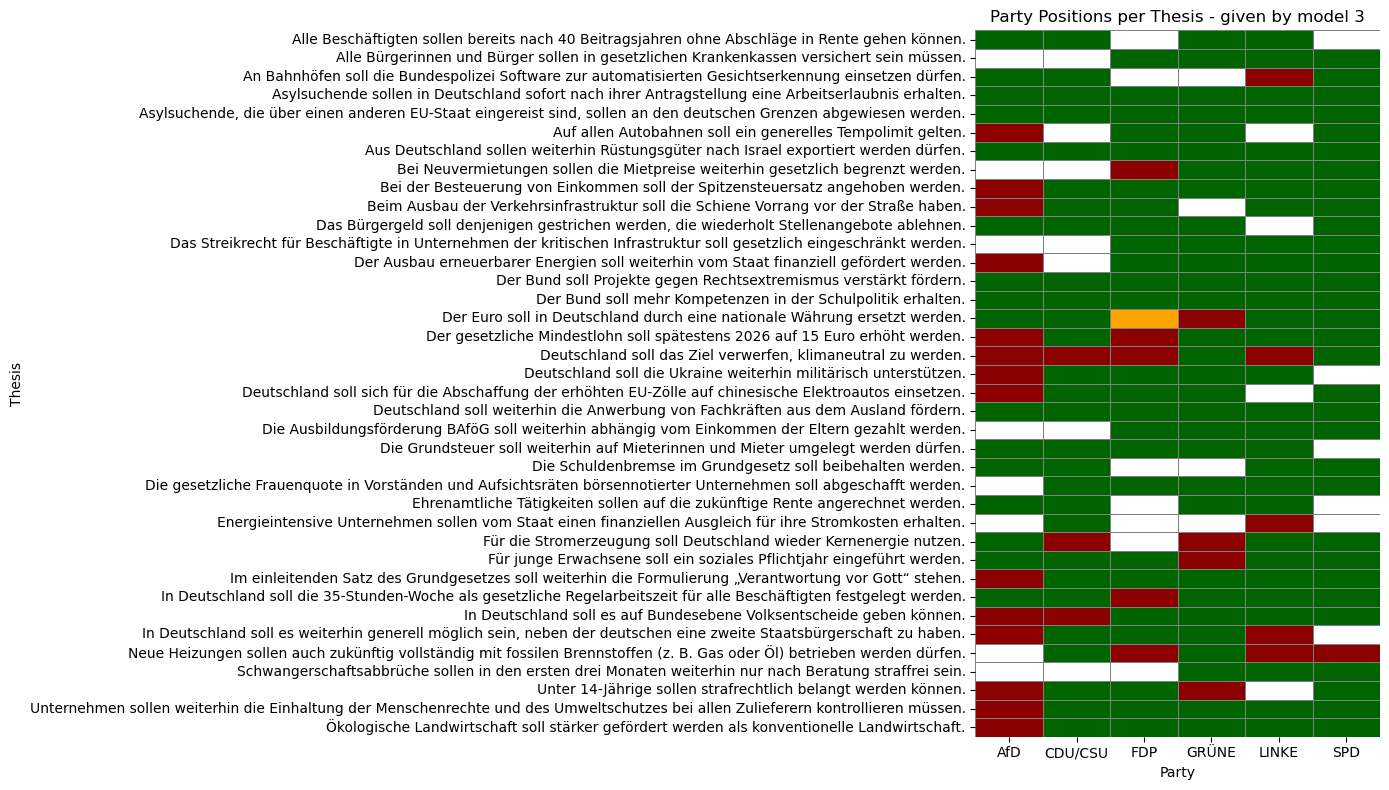

In [8]:
visualize("model_3_cat")

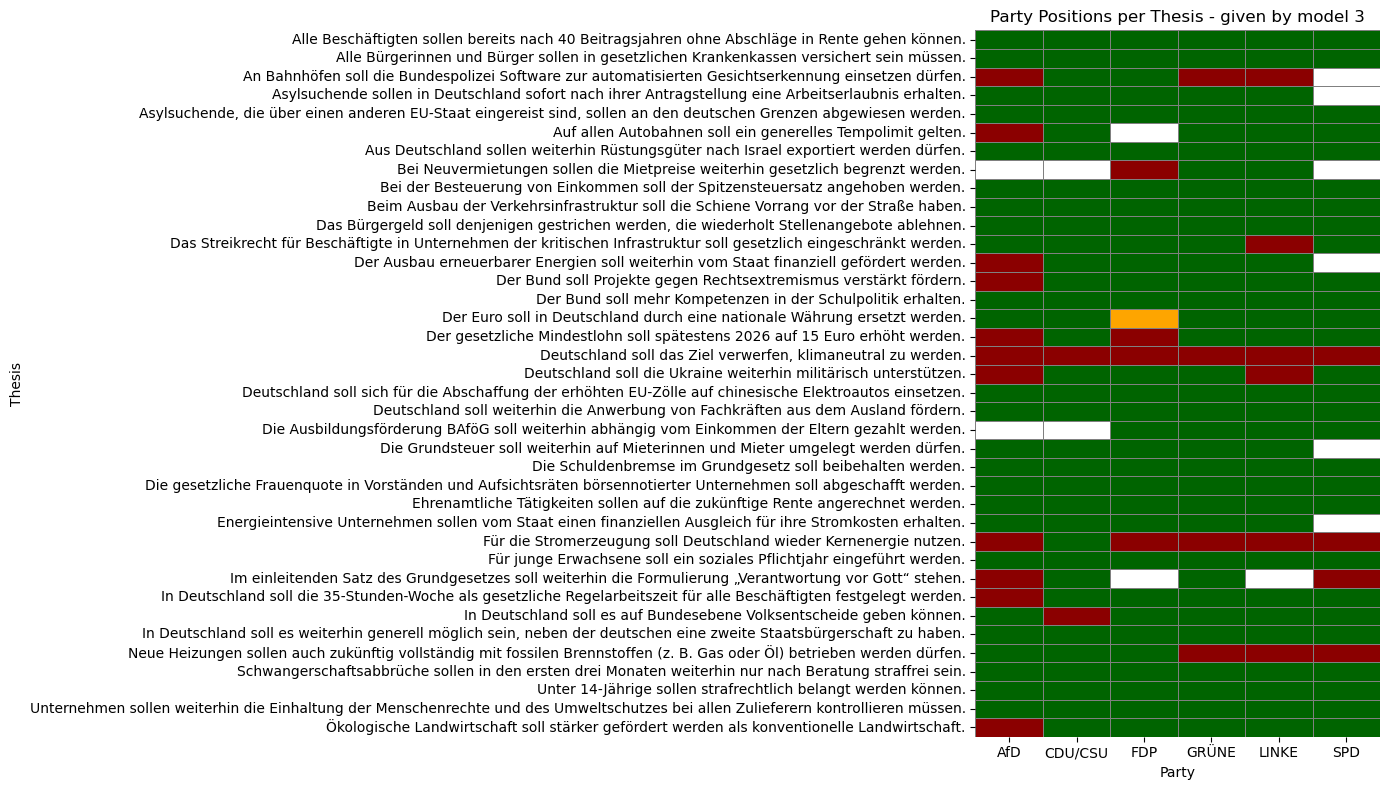

In [9]:
visualize("model_1_cat")

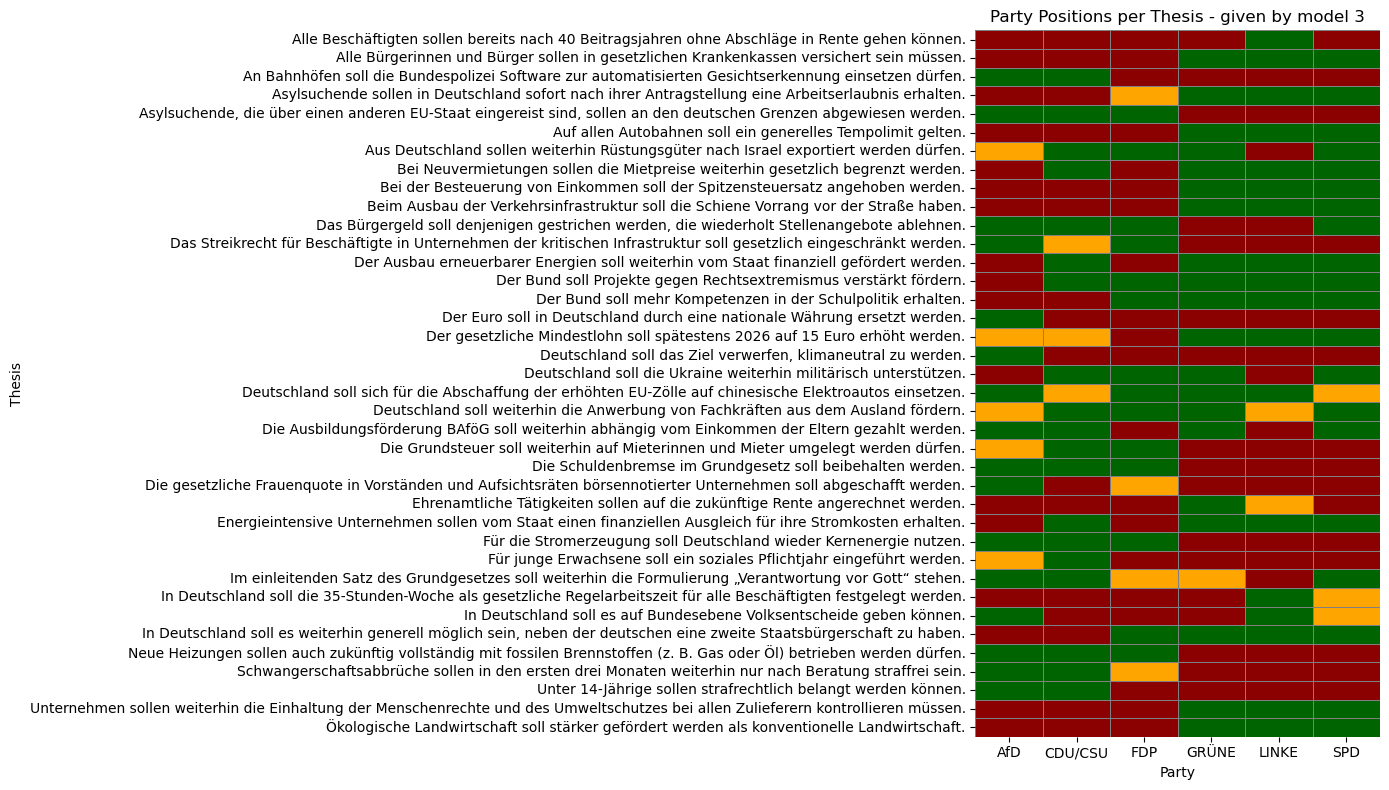

In [15]:
# truth
visualize("answer")

_______________________________________________________________________________
Compare real answers with model answers
________________________________________________________________________________

In [10]:
# define function to display eval metrics
def get_metrics(true_labels, preds, model_name):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Reds')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary



/Users/ellaalle/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Model: Model_1
  Accuracy: 0.5175438596491229
  Balanced Accuracy: 0.37050479387835344
  Precision: 0.32196368764322225
  Recall: 0.2778785954087651
  F1-score: 0.25162120432321156
  Classification Report:
                 precision    recall  f1-score   support

           None       0.00      0.00      0.00         0
        neutral       0.00      0.00      0.00        18
stimme nicht zu       0.77      0.23      0.36       103
      stimme zu       0.51      0.88      0.65       107

       accuracy                           0.52       228
      macro avg       0.32      0.28      0.25       228
   weighted avg       0.59      0.52      0.47       228



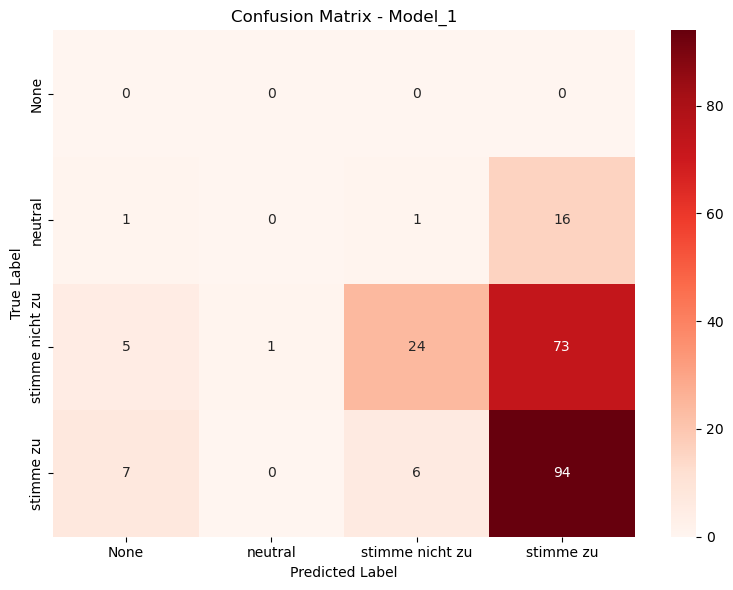

In [11]:
model_1 = get_metrics(wahlomat_data["answer"], wahlomat_data["model_1_cat"], "Model_1")

/Users/ellaalle/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Model: Model_3
  Accuracy: 0.4473684210526316
  Balanced Accuracy: 0.3204185948038593
  Precision: 0.29766116352201255
  Recall: 0.24031394610289447
  F1-score: 0.23185742133110554
  Classification Report:
                 precision    recall  f1-score   support

           None       0.00      0.00      0.00         0
        neutral       0.00      0.00      0.00        18
stimme nicht zu       0.69      0.21      0.33       103
      stimme zu       0.50      0.75      0.60       107

       accuracy                           0.45       228
      macro avg       0.30      0.24      0.23       228
   weighted avg       0.55      0.45      0.43       228



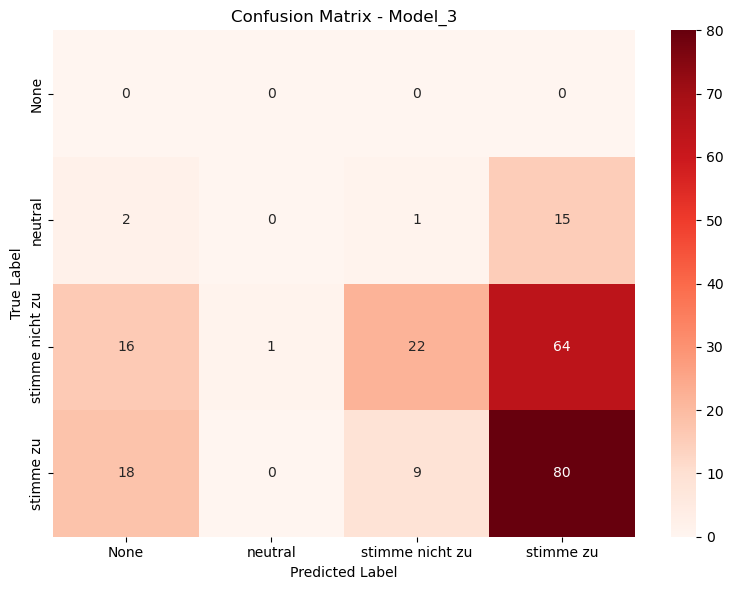

In [12]:
model_3 = get_metrics(wahlomat_data["answer"], wahlomat_data["model_3_cat"], "Model_3")

_____________________________________________________________________________________
Final Comparison
_____________________________________________________________________________________

In [13]:
# merge dictionaries
combined_results = {**model_1, **model_3}

# Convert to DataFrame
df = pd.DataFrame.from_dict(combined_results, orient='index')
df

,acc,bal_acc,precision,recall,f1
Model_1,0.517544,0.370505,0.321964,0.277879,0.251621
Model_3,0.447368,0.320419,0.297661,0.240314,0.231857
